# North Atlantic Basin

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.c24f44dbe9e14825aa495fba8083810c/status,


In [41]:
cluster.close()
client.close()

In [2]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
import gsw
from xhistogram.xarray import histogram

In [3]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()

In [4]:
#Load in tendencies

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [5]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tracer_tendencies_40yr.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/drhodts_tendencies_40yr.zarr'))
rho_cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/rho_bih_cab_tendencies_40yr.zarr'))

tendencies = xr.merge([tracers, drhodts, rho_cab])

In [6]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 14965, nlat: 2400, nlon: 3600)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [7]:
#New ds after dthetadt*drhodt and dSdt*drhods
def new_ds(ds):
    newds = xr.merge([(ds['SST_bih']*ds['drhodt']).rename('sst'),
                      (ds['SSS_bih']*ds['drhods']).rename('sss'),
                       ds['rho_bih'].rename('rho'),
                       ds['cabbeling']])
    return newds

In [8]:
tend = new_ds(tendencies)

In [9]:
tend

<xarray.Dataset>
Dimensions:    (nlat: 2400, nlon: 3600, time: 14965)
Coordinates:
  * nlat       (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon       (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    sst        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    sss        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

# 1) Spatial map of NASTMW outcropping in each month

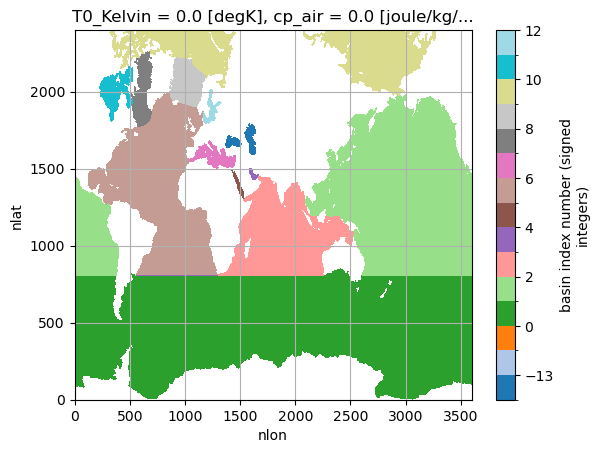

In [30]:
regions = np.unique(cesm.REGION_MASK)
cesm.REGION_MASK.where(cesm.KMT>0).plot.contourf(levels=regions, cmap='tab20')
plt.grid();

In [10]:
mask = cesm.REGION_MASK.reset_coords(drop=True)

In [11]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [23]:
#combine natl mask w/ norwegian and labrador seas
atl_mask = (mask>=atlantic_ocean) & (mask<=norwegian_sea) & (mask!=med_sea)

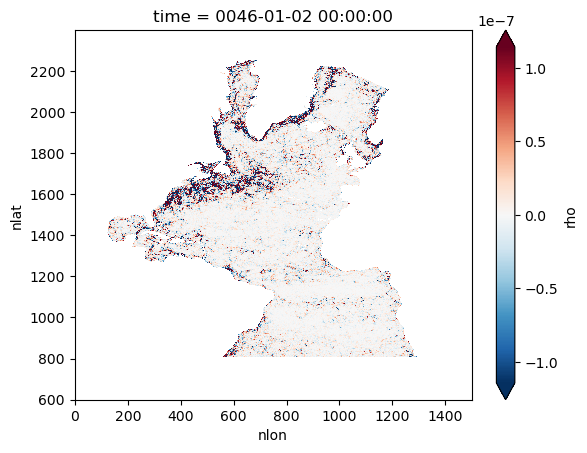

In [22]:
tend.rho.where(atl_mask).isel(time=0).isel(nlon=slice(0, 1500), nlat=slice(600, None)).plot(robust=True)

In [24]:
rho = gsw.sigma0(cesm.SSS, cesm.SST).rename('rho')
delta_rho = 0.1
rho_bins = np.arange(15, 35, delta_rho)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sigma0
  return func(*(_execute_task(a, cache) for a in args))


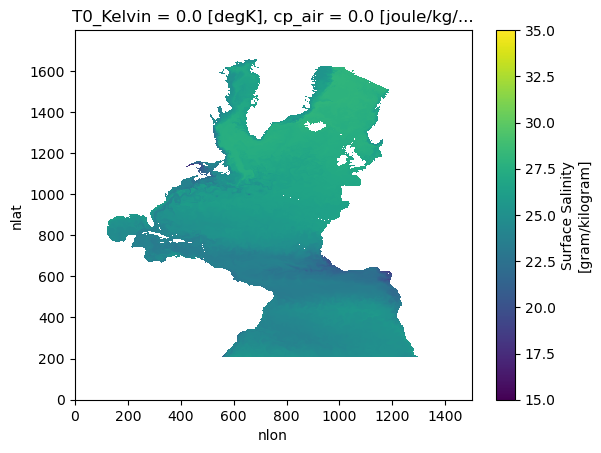

In [26]:
rho[0].where(atl_mask).isel(nlon=slice(0, 1500), nlat=slice(600, None)).plot(vmin=15, vmax=35)

In [38]:
rho_bins[115]

26.499999999999957

In [43]:
#plot contour of 26.5 isopycnal - rep NASTMW
fig, ax = plt.subplots(figsize=(10,5))
selection = dict(nlon=slice(0,1500), nlat=slice(200, None))

rho[0].where(atl_mask).isel(**selection).plot(vmin=15, vmax=35, ax=ax)
C = rho[0].where(atl_mask).isel(**selection).plot.contour(levels=[115], ax=ax, add_colorbar=True)
#C.collections[115].set_color('k')
#C.collections[115].set_linewidth(1.5);
#plt.clabel(C);

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sigma0
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sigma0
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/matplotlib/colorbar.py:1243: RuntimeWarning: divide by zero encountered in divide
  y = y / (self._boundaries[self._inside][-1] -
/srv/conda/envs/notebook/lib/python3.10/site-packages/matplotlib/colorbar.py:1243: RuntimeWarning: invalid value encountered in divide
  y = y / (self._boundaries[self._inside][-1] -


type: index 1 is out of bounds for axis 0 with size 1

Error in callback <function _draw_all_if_interactive at 0x7f79a466b910> (for post_execute):


IndexError: index 1 is out of bounds for axis 0 with size 1

IndexError: index 1 is out of bounds for axis 0 with size 1

<Figure size 1000x500 with 3 Axes>

# Split the tendencies to NATL basin

In [25]:
all_tendencies = list(tend)

In [20]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(ds.REGION_MASK==basin)
    return tendency_in_basin

In [49]:
#Atlantic Ocean
atl_ocean = xr.merge([tend[var].where(atl_mask).rename(var) for var in all_tendencies])

In [50]:
atl_ocean

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965)
Coordinates: (12/54)
  * nlat                (nlat) int64 0 1 2 3 4 5 ... 2395 2396 2397 2398 2399
  * nlon                (nlon) int64 0 1 2 3 4 5 ... 3595 3596 3597 3598 3599
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:0...
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    salt_to_ppt         float64 0.0
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
Data variables:
    sst                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    sss                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling           (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [53]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.281c0e91d36544559ac809e956ea520c/status,


In [ ]:
atl_ocean.rho.plot(robust=True)

# NATL histogram

In [18]:
avg_mld = (cesm.HMXL_2*1e-2).mean('time').compute()
cm2_to_m2 = 1e-4
weights = cesm.TAREA*cm2_to_m2*avg_mld

In [54]:
atl_hist = xr.merge([(histogram(rho.where(atl_mask), 
                               bins=[rho_bins], 
                               weights=(atl_ocean[var].fillna(0.)*weights.where(atl_mask)), 
                               dim=['nlon']) / delta_rho) for var in all_tendencies])

Task exception was never retrieved
future: <Task finished name='Task-248636' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248637' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248638' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/li

CommClosedError: in <TLS (closed) ConnectionPool.gather local=tls://10.0.80.3:53630 remote=gateway://traefik-prod-dask-gateway.prod:80/prod.281c0e91d36544559ac809e956ea520c>: Stream is closed

In [56]:
atl_hist

NameError: name 'atl_hist' is not defined

In [57]:
client.close()
cluster.close()